# 📌 1. Loading the Dataset

In [239]:
from os.path import join as path_join
import kagglehub
import numpy as np
import pandas as pd
import seaborn as sns
from holoviews.ipython import display
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import zscore
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) # suppress mathematically undefined errors


In [240]:
# Load dataset from URL
data_root = kagglehub.dataset_download("andrewkronser/cve-common-vulnerabilities-and-exposures")


## 💡 **Interpretation**:

-  **mod_date: The date the entry was last modified.**
 -  **pub_date: The date the entry was published.**
 -  **cvss: Common Vulnerability Scoring System (CVSS) score, a measure of the severity of a vulnerability.**
-  **cwe_code: Common Weakness Enumeration (CWE) code, identifying the type of weakness.**
 -  **cwe_name: The name associated with the CWE code.**
 -  **summary: A text summary of the vulnerability.**
-  **access_authentication.**
-  **access_complexity: how difficult it is to execute.**
-  **access_vector: how the attack is performed, aka via network or locally.**

In [241]:
# Read the dataset into a pandas dataframe
df = pd.read_csv(path_join(data_root, 'cve.csv'), header=0, index_col=0)
df.mod_date = pd.to_datetime(df.mod_date)
df.pub_date = pd.to_datetime(df.pub_date)

# Check for missing values before summary statistics
print("\nMissing Values:")
print(df.isnull().sum())

# General information about the DataFrame (column names, non-null counts, data types)
print("\nDataset Info:")
df.info()


non_par_com = {"NONE": 0, "COMPLETE": 2, "PARTIAL": 1}
low_med_hih = {"LOW": 0, "MEDIUM": 1, "HIGH": 2}
non_sin_mul = {"NONE": 0, "SINGLE": 1, "MULTIPLE": 2}
loc_adj_net = {"LOCAL": 0, "ADJACENT_NETWORK": 1, "NETWORK": 2}

ordinal_remapping = {
    "access_authentication": non_sin_mul,
    "access_complexity": low_med_hih,
    "access_vector": loc_adj_net,
    "impact_availability": non_par_com,
    "impact_confidentiality": non_par_com,
    "impact_integrity": non_par_com,
}

for ordinal_column in ordinal_remapping:
    df[ordinal_column] = df[ordinal_column].apply(
        lambda v: ordinal_remapping[ordinal_column].get(v, v)
    )



Missing Values:
mod_date                    0
pub_date                    0
cvss                        0
cwe_code                    0
cwe_name                    0
summary                     0
access_authentication     884
access_complexity         884
access_vector             884
impact_availability       884
impact_confidentiality    884
impact_integrity          884
dtype: int64

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 89660 entries, CVE-2019-16548 to CVE-2007-3004
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   mod_date                89660 non-null  datetime64[ns]
 1   pub_date                89660 non-null  datetime64[ns]
 2   cvss                    89660 non-null  float64       
 3   cwe_code                89660 non-null  int64         
 4   cwe_name                89660 non-null  object        
 5   summary                 89660 non-null  objec

In [242]:
# Summary statistics for numeric columns (e.g., mean, min, max)
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
                            mod_date                       pub_date  \
count                          89660                          89660   
mean   2017-09-26 16:10:18.163952640  2015-03-10 06:07:30.900067072   
min              2008-01-10 05:00:00            1999-01-01 05:00:00   
25%              2017-07-14 14:51:45            2012-04-25 10:10:00   
50%              2018-03-05 15:56:30            2016-08-08 01:59:00   
75%              2019-04-05 18:16:30            2018-06-17 16:29:00   
max              2019-11-21 15:15:00            2019-11-21 15:15:00   
std                              NaN                            NaN   

               cvss      cwe_code  access_authentication  access_complexity  \
count  89660.000000  89660.000000           88776.000000       88776.000000   
mean       6.021429    199.690854               0.135419           0.512470   
min        0.000000      1.000000               0.000000           0.000000   
25%        4.300000    

In [243]:
# Display the column names
print(df.columns.tolist())

['mod_date', 'pub_date', 'cvss', 'cwe_code', 'cwe_name', 'summary', 'access_authentication', 'access_complexity', 'access_vector', 'impact_availability', 'impact_confidentiality', 'impact_integrity']


# 🧼 2. Handling Missing Data

In [244]:
# Check for missing values in each column
missing_counts = df.isnull().sum()
print("Missing Data Count:\n", missing_counts)

# Remove rows with missing values
cleaned_df = df.dropna()
print("\nCleaned DataFrame Head:")
print(cleaned_df.head())


Missing Data Count:
 mod_date                    0
pub_date                    0
cvss                        0
cwe_code                    0
cwe_name                    0
summary                     0
access_authentication     884
access_complexity         884
access_vector             884
impact_availability       884
impact_confidentiality    884
impact_integrity          884
dtype: int64

Cleaned DataFrame Head:
                          mod_date            pub_date  cvss  cwe_code  \
CVE-2019-2211  2019-11-14 21:36:00 2019-11-13 18:15:00   7.8        89   
CVE-2019-2212  2019-11-14 21:30:00 2019-11-13 18:15:00   4.9       200   
CVE-2019-2213  2019-11-14 21:24:00 2019-11-13 18:15:00   6.9       416   
CVE-2019-2214  2019-11-14 21:19:00 2019-11-13 18:15:00   7.2       269   
CVE-2019-18793 2019-11-14 21:14:00 2019-11-13 20:15:00   4.3        79   

                                                         cwe_name  \
CVE-2019-2211    Improper Neutralization of Special Elements u...  

In [245]:
# Extract the 'summary' column as a NumPy array
summary_array = df['summary'].to_numpy()

# Show the first 10 values to understand the data
print(summary_array[:10])

['A cross-site request forgery vulnerability in Jenkins Google Compute Engine Plugin 4.1.1 and earlier in ComputeEngineCloud#doProvision could be used to provision new agents.'
 'Missing permission checks in various API endpoints in Jenkins Google Compute Engine Plugin 4.1.1 and earlier allow attackers with Overall/Read permission to obtain limited information about the plugin configuration and environment.'
 'Jenkins Google Compute Engine Plugin 4.1.1 and earlier does not verify SSH host keys when connecting agents created by the plugin, enabling man-in-the-middle attacks.'
 'Cross-site Scripting (XSS) in Dolibarr ERP/CRM 3.3.1 allows remote attackers to inject arbitrary web script or HTML in functions.lib.php.'
 "SQL injection vulnerability in Dolibarr ERP/CRM 3.3.1 allows remote attackers to execute arbitrary SQL commands via the 'pays' parameter in fiche.php."
 'MediaWiki before 1.19.4 and 1.20.x before 1.20.3 contains an error in the api.php script which allows remote attackers to

# 3. Time-Series Data

In [246]:
# Convert 'pub_date' column to datetime format
# df['pub_date'] = pd.to_datetime(df['pub_date'])  # Convert to datetime format
# df.set_index('pub_date', inplace=True) # Display the converted dates

In [247]:
# General count of events over time
df['pub_year'] = df.index.year
year_x_count = df.groupby("pub_year").size().reset_index(name="count")
fig = px.line(year_x_count, x="pub_year", y="count", log_y=True, title="CVE Count Over Time (Log Scale)")
fig.show()

AttributeError: 'Index' object has no attribute 'year'

In [229]:
# Slice time-series data by date range
print("Slicing Time-Series Data (January 2 to January 5, 2023):")
print(Improper_Input_Validation_time_series_df['2021-01-02':'2023-01-05'])  # Show specific date range

Slicing Time-Series Data (January 2 to January 5, 2023):
            Times
2023-01-01    307
2023-01-02    387
2023-01-03    409
2023-01-04    321
2023-01-05    415


In [230]:
# Extract year, month, and day from the datetime index
df['Year'] = df.index.year  # Extract year
df['Month'] = df.index.month  # Extract month
df['Day'] = df.index.day  # Extract day
print(df[['Year', 'Month', 'Day']].head(10))  # Display the extracted columns

                     Year  Month  Day
pub_date                             
2019-11-21 15:15:00  2019     11   21
2019-11-21 15:15:00  2019     11   21
2019-11-21 15:15:00  2019     11   21
2019-11-20 21:15:00  2019     11   20
2019-11-20 20:15:00  2019     11   20
2019-11-20 20:15:00  2019     11   20
2019-11-20 20:15:00  2019     11   20
2019-11-20 20:15:00  2019     11   20
2019-11-20 19:15:00  2019     11   20
2019-11-20 19:15:00  2019     11   20


In [231]:
# Calculate time differences from the earliest date
print("Calculating Time Differences from the Start Date:")
df['Time_from_start'] = df.index - df.index.min()  # Calculate timedelta from the first date
print(df[['Time_from_start']].head())  # Display the time differences

Calculating Time Differences from the Start Date:
                       Time_from_start
pub_date                              
2019-11-21 15:15:00 7629 days 10:15:00
2019-11-21 15:15:00 7629 days 10:15:00
2019-11-21 15:15:00 7629 days 10:15:00
2019-11-20 21:15:00 7628 days 16:15:00
2019-11-20 20:15:00 7628 days 15:15:00


# 📐 4. Probability Distribution & Descriptive Stats

**The McCumber Cube is a model framework created by John McCumber in 1991 to help organizations establish and evaluate information security initiatives by considering all of the related factors that impact them.**

**This security model has three dimensions:**

**The foundational principles for protecting information systems.**

**1.availability, 2.integrity, 3.Confidentiality ✅**

**The protection of information in each of its possible states.**

**The security measures used to protect data.**

## 4.1 Minimum and Maximum Values

In [37]:
# Min and Max of DataFrame columns
print("Minimum values in each column:")
print(df.min(numeric_only=True))

print("\nMaximum values in each column:")
print(df.max(numeric_only=True))


Minimum values in each column:
cvss                      0.0
cwe_code                  1.0
access_authentication     0.0
access_complexity         0.0
access_vector             0.0
impact_availability       0.0
impact_confidentiality    0.0
impact_integrity          0.0
dtype: float64

Maximum values in each column:
cvss                        10.0
cwe_code                  1188.0
access_authentication        2.0
access_complexity            2.0
access_vector                2.0
impact_availability          2.0
impact_confidentiality       2.0
impact_integrity             2.0
dtype: float64


## 4.2 Geometric Mean

In [38]:
# Calculate the geometric mean of cvss
geometric_mean_cvss = stats.gmean(df["cvss"].dropna())
print(f"\nGeometric Mean of cvss: {geometric_mean_cvss:.2f}")

# Calculate the geometric mean of cwe_code
geometric_mean_cwe_code = stats.gmean(df["cwe_code"].dropna())
print(f"\nGeometric Mean of cwe_code: {geometric_mean_cwe_code:.2f}")



Geometric Mean of cvss: 0.00

Geometric Mean of cwe_code: 134.06


## 3.3 Median and Mode

In [167]:
# Calculate median cwe_code
median_cwe_code = df["cwe_code"].median()
print(f"Median cwe_code: {median_cwe_code}")

# Calculate the mode of cwe_code
mode_cwe_code = df["cwe_code"].mode()
print(f"Most Common cwe_code: {mode_cwe_code[0]}, Count: {df['cwe_code'].value_counts()[mode_cwe_code[0]]}")


Median cwe_code: 119.0
Most Common cwe_code: 119, Count: 12344


In [254]:
# Plot the top 10 codes by pub_date in the most recent year

plt.figure(figsize=(12, 6))  # Set the figure size for better readability

# Extract the year
df['year'] = df['pub_date'].dt.year

# Get the most recent year
most_recent_year = df['year'].max()

# Get the top 10 most frequent 'cwe_code' values in the most recent year
top10_cwe_codes = recent_df['cwe_code'].value_counts().nlargest(10).index

# Filter the DataFrame for only the top 10 cwe_codes
top10_df = recent_df[recent_df['cwe_code'].isin(top10_cwe_codes)]

# For each of the top 10 cwe_codes, get the first pub_date
plot_data = top10_df.groupby('cwe_code')['pub_date'].first().reset_index()

# Line plot of codes vs. pub_date
plt.plot(
    plot_data['cwe_code'], 
    plot_data['pub_date'],
    marker='o', linestyle='-', color='b'
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add titles and axis labels
plt.title(f"Top 10 cwe_codes by frequency in {most_recent_year}")
plt.ylabel("pub_date")
plt.xlabel("cwe_code")

# Adjust layout to prevent label overlap
plt.tight_layout()

# Display the plot
plt.show()

KeyError: 'pub_date'

<Figure size 1200x600 with 0 Axes>

## 3.5 Quantiles and Interquartile Range (IQR)

Q1 (25th percentile of cwe_code): 79.00
Q3 (75th percentile of cwe_code): 284.00
Interquartile Range (IQR) of cwe_code: 205.00


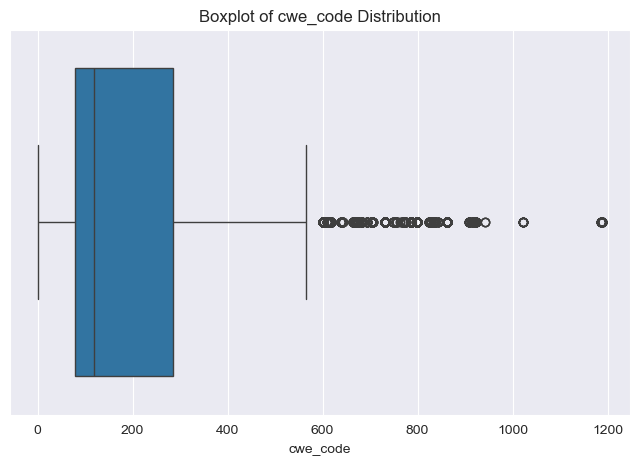

In [184]:
# Convert 'pub_date' column to datetime format
# df['pub_date'] = pd.to_datetime(df['pub_date']) , y=df["pub_date"]
# Calculate Q1 (25th percentile), Q3 (75th percentile), and IQR for cwe_code
q1_cwe_code = df["cwe_code"].quantile(0.25)
q3_cwe_code = df["cwe_code"].quantile(0.75)
iqr_cwe_code = q3_cwe_code - q1_cwe_code

print(f"Q1 (25th percentile of cwe_code): {q1_cwe_code:.2f}")
print(f"Q3 (75th percentile of cwe_code): {q3_cwe_code:.2f}")
print(f"Interquartile Range (IQR) of cwe_code: {iqr_cwe_code:.2f}")

# Visualize IQR using a boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x=df["cwe_code"])
plt.title("Boxplot of cwe_code Distribution")
plt.show()



# 📊 4.Visualising Relationships

## 📊 4.1 Distribution Shapes


Value counts of 'cwe_name' entries containing 'Improper':
cwe_name
Improper Restriction of Operations within the Bounds of a Memory Buffer                        12344
Improper Neutralization of Input During Web Page Generation ('Cross-site Scripting')           12339
Improper Input Validation                                                                       7884
Improper Neutralization of Special Elements used in an SQL Command ('SQL Injection')            5758
Improper Limitation of a Pathname to a Restricted Directory ('Path Traversal')                  3071
Improper Control of Generation of Code ('Code Injection')                                       2419
Improper Authentication                                                                         1802
Improper Access Control                                                                         1658
Improper Neutralization of Special Elements used in an OS Command ('OS Command Injection')       829
Concurrent Execution us

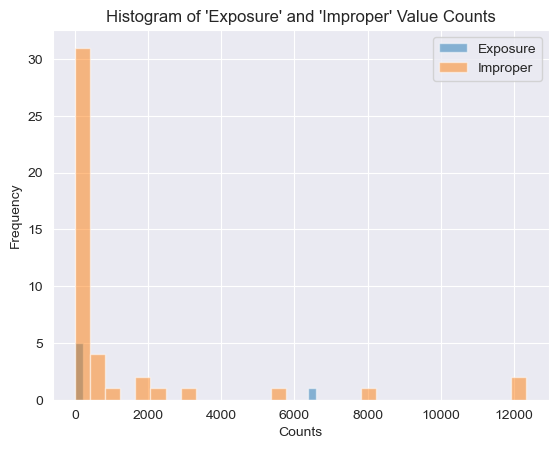

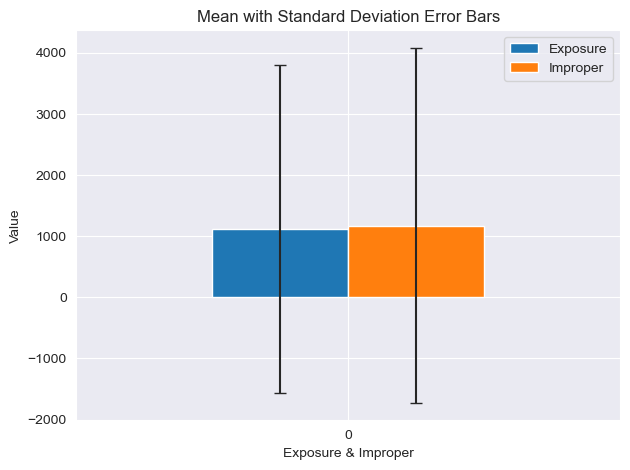

In [159]:
# Value counts of all entries in 'cwe_name' that contain 'Improper'
improper_value_counts = df.loc[df['cwe_name'].str.contains('Improper', case=False, na=False), 'cwe_name'].value_counts()
print(f"\nValue counts of 'cwe_name' entries containing 'Improper':\n{improper_value_counts}")

# Create a new DataFrame from the value counts
improper_counts_df = pd.DataFrame({'cwe_name': improper_value_counts.index, 'count': improper_value_counts.values})

# Calculate mean, variance, and std of the 'val' column in improper_counts_df
improper_mean_val = improper_counts_df['count'].mean()
improper_var_val =  improper_counts_df['count'].var()     # sample variance
improper_std_val =  improper_counts_df['count'].std()     # sample standard deviation

print(f"Mean (Expected Value) for Improper: {improper_mean_val:.4f}")
print(f"Variance for Improper: {improper_var_val:.4f}")
print(f"Standard Deviation for Improper: {improper_std_val:.4f}")


# Value counts of all entries in 'cwe_name' that contain 'Exposure'
Exposure_value_counts = df.loc[df['cwe_name'].str.contains('Exposure', case=False, na=False), 'cwe_name'].value_counts()
print(f"\nValue counts of 'cwe_name' entries containing 'Exposure':\n{Exposure_value_counts}")

# Create a new DataFrame from the value counts
Exposure_counts_df = pd.DataFrame({'cwe_name': Exposure_value_counts.index, 'count': Exposure_value_counts.values})

# # Calculate mean, variance, and std of the 'val' column in Exposure_counts_df
Exposure_mean_val = Exposure_counts_df['count'].mean()
Exposure_var_val =  Exposure_counts_df['count'].var()     # sample variance
Exposure_std_val =  Exposure_counts_df['count'].std()     # sample standard deviation

print(f"Mean (Expected Value) for Exposure: {mean_val:.4f}")
print(f"Variance for Exposure: {var_val:.4f}")
print(f"Standard Deviation for Exposure: {std_val:.4f}")

# Create a DataFrame for the means and standard deviations
stats = pd.DataFrame({
    'Mean_Exposure': [Exposure_mean_val], 
    'Mean_Improper': [improper_mean_val],
    'Std_Exposure': [Exposure_std_val],
    'Std_Improper': [improper_std_val]
})

# Visualize distribution
plt.hist(Exposure_counts_df['count'], bins=30, alpha=0.5, label='Exposure')
plt.hist(improper_counts_df['count'], bins=30, alpha=0.5, label='Improper')
plt.title("Histogram of 'Exposure' and 'Improper' Value Counts")
plt.xlabel("Counts")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Create a DataFrame for the means
means = pd.DataFrame({'Exposure': [Exposure_mean_val], 'Improper': [improper_mean_val]})

# Create a DataFrame for the standard deviations
stds = pd.DataFrame({'Exposure': [Exposure_std_val], 'Improper': [improper_std_val]})

# Plot the bar chart with error bars
means.plot.bar(yerr=stds, rot=0, capsize=4) # capsize adds caps to error bars
plt.title("Mean with Standard Deviation Error Bars")
plt.xlabel('Exposure & Improper')
plt.ylabel("Value")
plt.tight_layout()
plt.show()

*Summary:*
**The histogram shows the distribution of the impact_confidentiality values in our dataset.**

**We also calculated key descriptive statistics:**

**- The mean value of approximately 0.8659 indicates the average confidentiality values in the dataset.**

**- The variance of 0.5085 tells us how spread out the values are — specifically, it’s the average of the squared differences from the mean.**

**- The standard deviation of 0.7131 shows that most of the confidentiality values are within ±0.7131 units of the mean.**

**-a more interpretable measure than variance since it shares the same units as the data.**

**- The histogram is asymmetric and slightly skewed, suggesting that the distribution is not perfectly normal.**

**- There's a wide spread in the values, ranging from slightly below 15000 to above 40000.**

## 📊 4.2 Poisson distribution

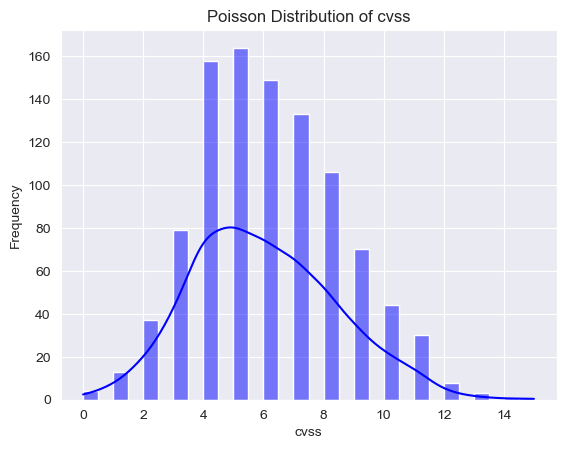

In [160]:
# Estimate the mean of cvss
lambda_value = df["cvss"].mean()

# Generate Poisson distribution
poisson_data = np.random.poisson(lam=lambda_value, size=1000)

# Plot distribution
sns.histplot(poisson_data, kde=True, bins=30, color="blue")
plt.title("Poisson Distribution of cvss")
plt.xlabel("cvss")
plt.ylabel("Frequency")
plt.show()



## 📦 4.3 Detect, Report, and Visualize Outliers Using Z-Score

Number of outliers detected per column:
 cvss                         1
cwe_code                  3026
access_authentication       23
access_complexity            0
access_vector                0
impact_availability          0
impact_confidentiality       0
impact_integrity             0
dtype: int64

--- Summary Statistics ---


,count,mean,std,min,25%,50%,75%,max
cvss,89660.0,6.021429,1.994757,0.0,4.3,5.8,7.5,10.0
cwe_code,89660.0,199.690854,176.177244,1.0,79.0,119.0,284.0,1188.0
access_authentication,88776.0,0.135419,0.342929,0.0,0.0,0.0,0.0,2.0
access_complexity,88776.0,0.512470,0.552613,0.0,0.0,0.0,1.0,2.0
access_vector,88776.0,1.744019,0.645709,0.0,2.0,2.0,2.0,2.0
impact_availability,88776.0,0.862609,0.758760,0.0,0.0,1.0,1.0,2.0
impact_confidentiality,88776.0,0.865943,0.713088,0.0,0.0,1.0,1.0,2.0
impact_integrity,88776.0,0.902079,0.684279,0.0,0.0,1.0,1.0,2.0



 Boxplots to Inspect Outliers:


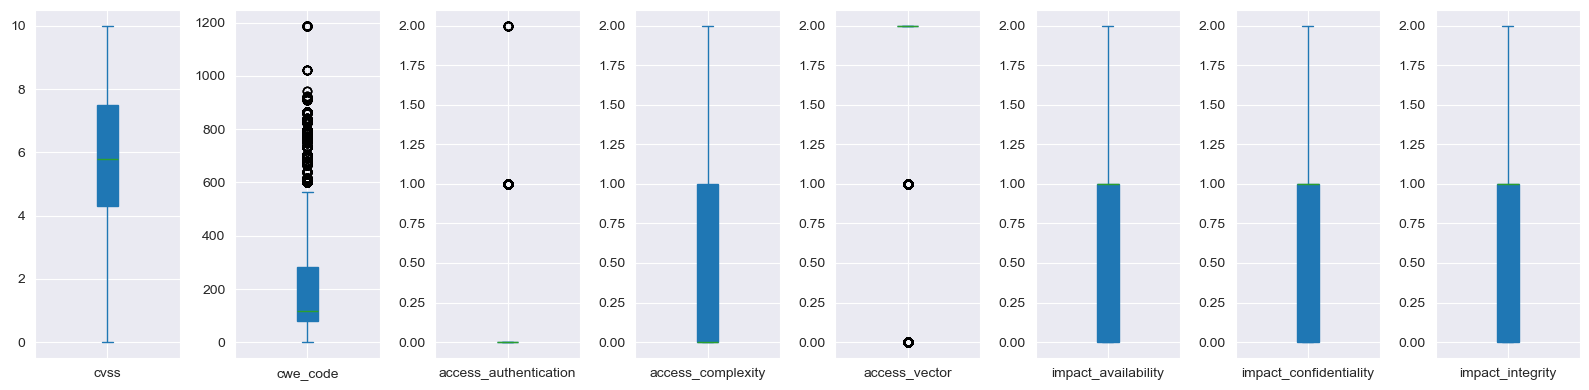

In [44]:
# Detect, Report, and Visualize Outliers Using Z-Score

def visualize_outliers(df, threshold=3):
    df_numeric = df.select_dtypes(include=['number'])

    # Calculate Z-scores
    z_scores = df_numeric.apply(zscore, nan_policy='omit')

    # Count how many values are considered outliers
    outlier_counts = (z_scores.abs() > threshold).sum()
    print("Number of outliers detected per column:\n", outlier_counts)

    # Summary statistics
    print("\n--- Summary Statistics ---")
    display(df_numeric.describe().T)

    # Boxplot visualization
    print("\n Boxplots to Inspect Outliers:")
    df_numeric.plot(kind='box', subplots=True, layout=(1, len(df_numeric.columns)), figsize=(16, 4), patch_artist=True)
    plt.tight_layout()
    plt.show()

# Apply outlier visualization
visualize_outliers(df)


## 🔗 5. Analysing Correlation Between Variables


Covariance Matrix:
                  cvss  rolling_mean
cvss          3.976185      0.664720
rolling_mean  0.664720      0.751204


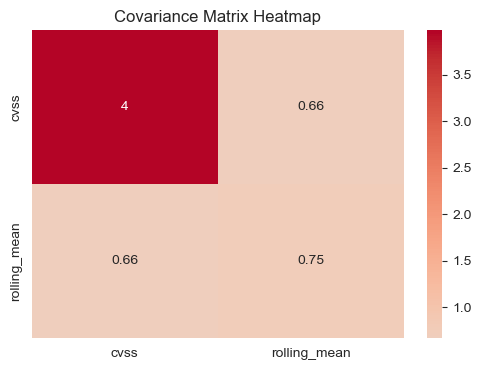

In [185]:
# Covariance Analysis

# Calculate a rolling mean to smooth out short-term fluctuations
df['rolling_mean'] = df['cvss'].rolling(window=30).mean()

# Remove rows with NaN values introduced by the rolling window
df_clean = df.dropna()

# Calculate the covariance matrix between the original values and their rolling mean
cov_matrix = df_clean[['cvss', 'rolling_mean']].cov()

# Display the covariance matrix
print("\nCovariance Matrix:")
print(cov_matrix)

# Visualize the covariance matrix using a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cov_matrix, annot=True, cmap="coolwarm", center=0)

# Add plot title
plt.title("Covariance Matrix Heatmap")

# Show the plot
plt.show()




Pearson Correlation:
              cvss  rolling_mean
cvss           1.0          -1.0
rolling_mean  -1.0           1.0

Spearman Correlation:
              cvss  rolling_mean
cvss           1.0          -1.0
rolling_mean  -1.0           1.0

Kendall Correlation:
              cvss  rolling_mean
cvss           1.0          -1.0
rolling_mean  -1.0           1.0


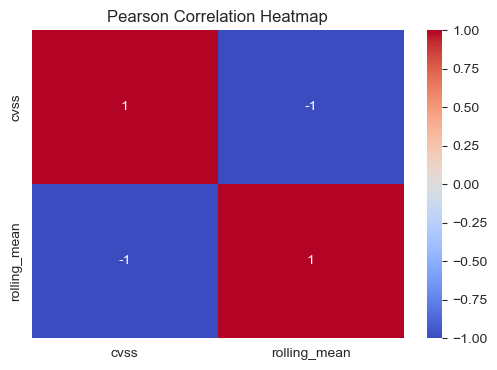

In [186]:
# Calculate correlation matrices using different methods:

pearson_corr = cov_matrix.corr(method='pearson') # - Pearson: linear correlation (assumes normality)
spearman_corr = cov_matrix.corr(method='spearman') # - Spearman: rank-based correlation (monotonic relationships)
kendall_corr = cov_matrix.corr(method='kendall') # - Kendall: rank correlation (more robust with small samples or ties)

# Display the correlation matrices
print("\nPearson Correlation:")
print(pearson_corr)

print("\nSpearman Correlation:")
print(spearman_corr)

print("\nKendall Correlation:")
print(kendall_corr)

plt.figure(figsize=(6, 4))
sns.heatmap(pearson_corr, annot=True, cmap="coolwarm", center=0)

# Add title
plt.title("Pearson Correlation Heatmap")

# Show plot
plt.show()



Model Evaluation:
Intercept: -232.31806401097475
Coefficient: 3.023460446065523e-07
R-squared: 0.05082548529127218
Mean Squared Error: 30146.4286878047


/var/folders/hb/3jl8x77x5k94tq98l6fz3cbr0000gn/T/ipykernel_5213/3850202549.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



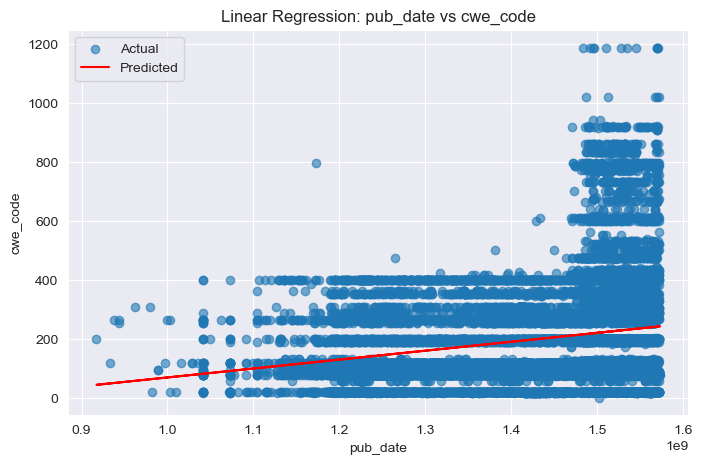

In [253]:
# Linear Regression with Scikit-Learn

# Convert 'pub_date' column to datetime format
# df['pub_date'] = pd.to_datetime(df['pub_date'])  # Convert to datetime format
# df.set_index('pub_date', inplace=True) # Display the converted dates
# Goal: Predict cwe_code based pub_date
# df_clean = df.dropna(subset=['pub_date', 'cwe_code'])

# Convert datetime to numeric for regression
df_clean['pub_date_numeric'] = df_clean.index.astype(np.int64) // 10**9  # Convert to Unix timestamp (seconds)

# Define features (independent variable) and target (dependent variable)
X = df_clean[['pub_date_numeric']]  # Feature: smoothed version of the value
y = df_clean['cwe_code']  # Target: original value

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and fit a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict values for the test set
y_pred = model.predict(X_test)

# Evaluate model performance
print("\nModel Evaluation:")
print("Intercept:", model.intercept_)  # The constant term (β₀)
print("Coefficient:", model.coef_[0])  # The slope (β₁) for rolling_mean
print("R-squared:", r2_score(y_test, y_pred))  # Proportion of variance explained
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))  # Average squared error

plt.figure(figsize=(8, 5))  # Set the figure size

# Scatter plot of actual test data
plt.scatter(X_test, y_test, label='Actual', alpha=0.6)

# Plot regression line (predicted values)
plt.plot(X_test, y_pred, color='red', label='Predicted')

# Add labels and title
plt.xlabel("pub_date")
plt.ylabel("cwe_code")
plt.title("Linear Regression: pub_date vs cwe_code")

# Add legend and show the plot
plt.legend()
plt.show()